# Analysis and plotting of RBD depletions for sera samles

### Set up Analysis

Import packages.

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
import natsort

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import numpy as np
import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Titration ELISAs

### Read ELISA Titration Data

I first manipulated the data in R and made a new CSV file that we can read in now. Here I:
* Concatenate files together (if there are multiple)
* Remove samples as indicated in config file
* Replace serum names with `display_names`
* Change `dilution` to `dilution factor`
* Take 1/dilution factor to get the dilution (i.e., a 1:100 dilution is `dilution_factor==100` and `dilution==0.01`

In [6]:
titration_df = pd.DataFrame() # create empty data frame

for f in config['elisa_input_files']:
    df = pd.read_csv(f)
    titration_df = titration_df.append(df)
    
titration_df = (pd.melt(titration_df, 
                        id_vars=['subject', 'timepoint', 'serum', 'depleted', 'round', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int))
               )

titration_df = (titration_df
                .assign(depleted= pd.Categorical(titration_df['depleted'], categories=['pre', 'post'], ordered=True),
                        dilution=lambda x: 1/x['dilution_factor'],
               )
                .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
       )

display(titration_df.head())  # display first few lines

,subject,timepoint,serum,depleted,round,ligand,date,dilution_factor,OD450,dilution
0,192C,9,192C-day-9,pre,no_depletion,RBD,91121,100,3.7513,0.01
1,192C,9,192C-day-9,post,round_1,RBD,91121,100,3.9545,0.01
2,192C,9,192C-day-9,post,round_2,RBD,91121,100,1.1357,0.01
3,192C,9,192C-day-9,post,round_3,RBD,91121,100,0.5324,0.01
4,192C,9,192C-day-9,post,round_4,RBD,91121,100,0.5513,0.01


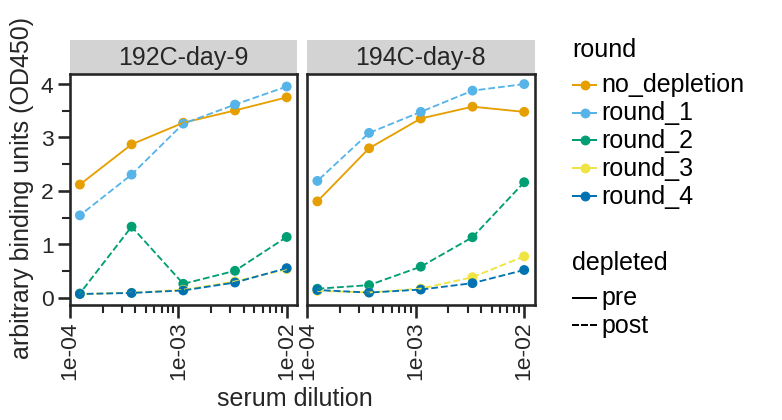

In [7]:
nconditions = df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

p = (
    ggplot((titration_df
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round')) +
    geom_point(size=3) +
    geom_path(aes(color='round', linetype='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=ncol) +
    theme(figure_size=(3 * ncol, 3 * nrow),
          axis_text_x=element_text(angle=90),
          subplots_adjust={'hspace':0.35},
         ) +
    scale_color_manual(values=CBPALETTE[1:]) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()